## Classification using a support vector machine

Multi-variate pattern analysis (MVPA) is becoming increasing popular in human electrophysiological research (Cichy et al., 2014; Stokes et al, 2015;). This approach allows for identifying representational specific information associated with distributed patterns of electrophysiological activity. In this example we demonstrate how a support vector machine (SVM) can be applied to classify two classes of trials.

## Preparation

Below are the required Python modules to be imported

In [1]:
import os.path as op
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import mne
from mne_bids import BIDSPath
from mne.decoding import (SlidingEstimator, GeneralizingEstimator, Scaler,
                          cross_val_multiscore, LinearModel, get_coef,
                          Vectorizer, CSP)

import sklearn.svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

**The classification is based on the tools in the Scikit-learn (#sklearn#) package.**

#### File overview

The chapter relies on the input file (embedded in the BIDS structure):

< BIDS_ROOT >/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif

Set the paths for the data and results. Note that these will depend on your local setup.


## Specify your BIDS parameters along with the BIDS folder path

In [2]:
subject = '01'
session = '01'Specify your BIDS parameters along with the BIDS folder path
task = 'SpAtt'  # name of the task
run = '12'  # we have two runs for this subject, let's look at run = 1
meg_suffix = 'meg'
epo_suffix = 'epo'

data_path='/home/rakshita/rds_folders/Sproject3/OPM_data'
deriv_root = op.join(data_path, "Sub2_BIDS/derivatives/analysis")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-12_epo.fif /home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif


In [3]:
epochs = mne.read_epochs(bids_path.fpath,
                         preload=True,
                         verbose=True).pick(['meg'])

Reading /home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif ...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 67) active
        HFC: l=1 m=0 (1 x 67) active
        HFC: l=1 m=1 (1 x 67) active
        HFC: l=2 m=-2 (1 x 67) active
        HFC: l=2 m=-1 (1 x 67) active
        HFC: l=2 m=0 (1 x 67) active
        HFC: l=2 m=1 (1 x 67) active
        HFC: l=2 m=2 (1 x 67) active
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
316 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)
8 projection items activated


Now filter the data. In this case we lowpass the data at 10 Hz. This is done before cutting the trials in shorter segments in order to reduce edge effects from the filtering. The filter also serves to perform temporal smoothing of the data which will benefit the classification.

In [4]:
epochs_rs = epochs.copy().filter(3,10)

Setting up low-pass filter at 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 1321 samples (1.321 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 647 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 881 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 1151 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1457 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done 1799 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done 2177 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 2591 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done 3041 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 3527 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done 4049 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done 4607 tasks      | elapsed:    1.1s
[Parallel(n_job

Down-sample the data to 100 Hz in order to reduce the compuatation time. Then set the time-window of interest to -0.1 to 0.5 s around the target onset.

In [5]:
epochs_rs.resample(100)
epochs_rs.crop(tmin=-0.1, tmax=0.5)

<EpochsFIF | 316 events (all good), -0.1 – 0.5 s (baseline off), ~10.4 MB, data loaded,
 'cue_left': 158
 'cue_right': 158>

## Setting up the Classifier

The SVM is implemented in the scikit-learn package and the corresponding application programming interface (API) must be applied. The matrix *X*
(features) is a three-dimensional matrix (trials x channel x time points).

In [6]:
X = epochs_rs.get_data(picks='meg') 
X.shape

(316, 67, 61)

In this case we have 316 trials and each trial has 61 timepoints. The vector *y* (target) contains 158 left trials and 158 right trials.The trial codes (5 & 6) needs to converted to the class labels 1 & 2.

In [7]:
epochs.events

array([[  65138,       0,       5],
       [  69920,       0,       5],
       [  74027,       0,       6],
       [  77824,       0,       6],
       [  81984,       0,       5],
       [  86385,       0,       5],
       [  90890,       0,       5],
       [  95914,       0,       5],
       [  99833,       0,       6],
       [ 104301,       0,       6],
       [ 109312,       0,       6],
       [ 113813,       0,       6],
       [ 122733,       0,       5],
       [ 129498,       0,       6],
       [ 134056,       0,       5],
       [ 142655,       0,       5],
       [ 146823,       0,       5],
       [ 150557,       0,       6],
       [ 155518,       0,       6],
       [ 160116,       0,       6],
       [ 165938,       0,       6],
       [ 170197,       0,       6],
       [ 174715,       0,       5],
       [ 179401,       0,       6],
       [ 183712,       0,       6],
       [ 188001,       0,       5],
       [ 192681,       0,       5],
       [ 196935,       0,   

In [8]:
temp = epochs.events[:, 2]
temp[epochs.events[:,2] == 5] = 1
temp[epochs.events[:,2] == 6] = 2
y = temp
print(y)

[1 1 2 2 1 1 1 1 2 2 2 2 1 2 1 1 1 2 2 2 2 2 1 2 2 1 1 1 1 1 2 2 1 2 1 2 1
 2 2 1 1 2 1 2 2 1 1 2 2 2 1 1 1 1 2 2 1 2 2 1 2 2 1 2 1 1 1 1 2 1 2 2 1 1
 1 2 2 2 1 2 1 1 2 1 1 1 2 2 1 1 2 1 2 2 2 1 2 2 2 2 1 1 2 2 2 2 2 1 1 1 1
 1 2 1 1 1 2 2 2 2 1 1 2 1 1 2 2 1 1 2 2 1 2 1 1 2 1 1 2 1 1 1 2 1 1 1 1 2
 1 2 1 2 2 2 2 1 2 1 2 2 2 1 1 2 1 2 1 1 2 1 1 1 1 1 2 1 1 2 1 2 2 2 1 1 1
 2 2 1 2 2 1 1 2 2 2 2 1 2 1 1 1 1 2 2 1 2 2 1 2 2 1 2 2 2 1 2 1 1 1 2 1 1
 2 1 1 2 2 2 2 2 2 1 2 1 2 2 1 2 1 1 2 2 2 2 1 1 2 1 2 2 1 2 2 1 1 2 1 2 1
 1 1 2 1 1 1 2 2 2 2 2 1 1 2 2 1 1 2 1 1 1 2 2 1 1 1 1 1 2 2 2 2 1 1 2 2 1
 2 2 2 2 1 1 1 1 1 2 1 1 2 2 2 2 2 1 1 2]


The function make_pipeline is from *scikit-learn*. It defines the transforms used with the estimator. The *Vectorizer()* transforms X into a 2D array (samples by features). The *StandardScaler()* standardize the data by removing the mean and scaling to unit variance.

In [10]:
clf = make_pipeline(Vectorizer(),StandardScaler(),  
                   LinearModel(sklearn.svm.SVC(kernel = 'linear')))   

Finally the estimator must be defined. We here apply the *SlidingEstimator* that uses the features and targets as input as well as *clf* defining the pipeline. The aim is to discriminate the experimental conditions as functions of time; i.e. at which time points can we tell left from right attention?

In [11]:
time_decod = SlidingEstimator(clf, n_jobs=-1, scoring='roc_auc', verbose=True)

## Performing the Classification

The classification will be performed timepoint by timepoint using a SVM by training on 80% of the trials on test on 20% in 5 runs. This results in a 5-fold cross-validation (cv=5). The output will be reported as Area Under the Curve (AUC).


In [12]:
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
 18%|█▊        | Fitting SlidingEstimator : 11/61 [00:00<00:00,  106.21it/s]
 36%|███▌      | Fitting SlidingEstimator : 22/61 [00:00<00:00,  158.48it/s]

 57%|█████▋    | Fitting SlidingEstimator : 35/61 [00:00<00:00,  134.87it/s]A
  3%|▎         | Fitting SlidingEstimator : 2/61 [00:00<00:04,   12.57it/s]
 67%|██████▋   | Fitting SlidingEstimator : 41/61 [00:00<00:00,  134.94it/s][A


  0%|          | Fitting SlidingEstimator : 0/61 [00:00<?,       ?it/s]
 70%|███████   | Fitting SlidingEstimator : 43/61 [00:00<00:00,  122.78it/s][A



  0%|          | Fitting SlidingEstimator : 0/61 [00:00<?,       ?it/s]

  7%|▋         | Fitting SlidingEstimator : 4/61 [00:00<00:02,   19.86it/s]
 75%|███████▌  | Fitting SlidingEstimator : 46/61 [00:00<00:00,  113.48it/s]

  8%|▊         | Fitting SlidingEstimator : 5/61 [00:00<00:02,   20.94it/s]
 77%|███████▋  | Fitting SlidingEstimator : 47/61 [00:00<00:00,  105.19it/s]

## Plotting the Results

**In order to plot the results,average over scores and plot**

In [13]:
scores = np.mean(scores, axis=0)

Text(0.5, 1.0, 'Sensor space decoding OPM data')

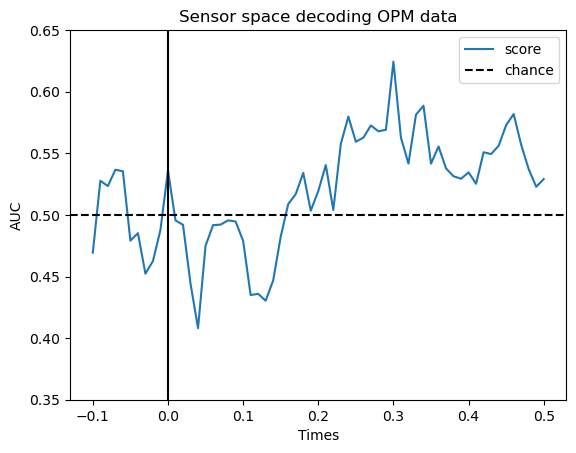

In [26]:
fig, ax = plt.subplots()
plt.ylim([0.35, 0.65])
ax.plot(epochs_rs.times, scores, label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.set_xlabel('Times')
ax.set_ylabel('AUC')  # Area Under the Curve
ax.legend()
ax.axvline(.0, color='k', linestyle='-')
ax.set_title('Sensor space decoding OPM data')

**The plots show the accuracy (AUC) of the classification as a function of time. The best classiciation is obtained ~300 ms after the target onset and is about 0.63.**


## References

* Cichy RM, Pantazis D, Oliva A.(2014) Resolving human object recognition in space and time. Nat Neurosci. 17(3):455-62. doi: 10.1038/nn.3635
* Cortes, C, Vapnik, V (1995) Support-vector networks. Mach Learn 20, 273–297
* Stokes MG, Wolff MJ, Spaak E. (2015) Decoding Rich Spatial Information with High Temporal Resolution. Trends Cogn Sci. 19(11):636-638. doi: 10.1016/j.tics.2015.08.016
* Duda, Richard O., and Peter E. Hart. Pattern classification. John Wiley & Sons, 2006.

